<a href="https://colab.research.google.com/github/Jinukki/KJU/blob/master/DrugMid2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
def DownloadRDkit():
  !wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
  !chmod +x Miniconda3-latest-Linux-x86_64.sh
  !time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
  !time conda install -q -y -c conda-forge rdkit

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # warining 표시 안나오도록 하기

In [0]:
DownloadRDkit() # RDkit 다운로드
%matplotlib inline
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2019-12-12 15:06:43--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h7b6447c_0
    - conda==4.7.12=py37_0
    - cryptography==2.8=py37h1ba5d50_0
    - idna==2.8=py37_0
    - libedit==3.1.20181209=hc058

In [0]:
import os
import pandas as pd
import numpy as np
import sklearn
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from matplotlib import pyplot as plt
%matplotlib inline

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
smifile = "gdb11_size08.smi" # 데이터셋 받아오기
data = pd.read_csv(smifile, delimiter = "\t", names = ["smiles","No","Int"])
from sklearn.model_selection import train_test_split
smiles_train, smiles_test = train_test_split(data["smiles"], random_state=42)
print (smiles_train.shape)
print (smiles_test.shape)

(65560,)
(21854,)


In [0]:
data.sample(10) # 데이터셋 샘플 확인

,smiles,No,Int
64800,CC1C2OCC(=C)C12,64801,1
34205,CNc1c[nH]c(C)n1,34206,2
43576,N#CC=C1CCOC1,43577,1
17001,CN1CC(C1)OC=O,17002,1
25156,CC1(CCNC1)C=C,25157,1
7256,CC1(F)COC1C=C,7257,1
66807,CC1CN1C(=O)NN,46100,1
53598,O=COCCC1CN1,53599,1
43031,CCCCC1CNC1,43032,1
3524,CCC(=C)CN(C)C,3525,1


In [0]:
charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print (str(charset))
print(len(charset), embed)

{'N', '3', 'C', 'F', ')', '+', '!', '#', '2', 'o', '4', 'c', '[', '1', 'H', '-', 'O', '=', '(', 'E', 'n', ']'}
22 28


C1OC2CN3CC3C12


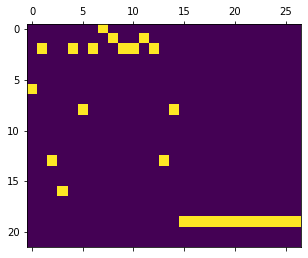

In [0]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]
X_train, Y_train = vectorize(smiles_train.values)
X_test,Y_test = vectorize(smiles_test.values)
print (smiles_train.iloc[0])
plt.matshow(X_train[0].T)
#print X_train.shape

In [0]:
"".join([int_to_char[idx] for idx in np.argmax(X_train[0,:,:], axis=1)])

'!C1OC2CN3CC3C12EEEEEEEEEEEE'

In [0]:
import tensorflow as tf

In [0]:
from tensorflow import keras

In [0]:
#Import Keras objects
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Concatenate
from keras import regularizers
input_shape = X_train.shape[1:]
output_dim = Y_train.shape[-1]
latent_dim = 64
lstm_dim = 64

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # warining 표시 안나오도록 하기

In [0]:
unroll = False
encoder_inputs = Input(shape=input_shape)
encoder = LSTM(lstm_dim, return_state=True, 
                unroll=unroll) # 상태정보 출력
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# encoder_outputs도 같이 리턴받기는 했지만 여기서는 필요없으므로 이 값은 버림.
# LSTM은 RNN과는 달리 상태가 두 개. 바로 은닉 상태와 셀 상태.
states = Concatenate(axis=-1)([state_h, state_c])
# 배열들을 연결해 배열 구하기
neck = Dense(latent_dim, activation="relu")
neck_outputs = neck(states) # context 벡터

In [0]:
decode_h = Dense(lstm_dim, activation="relu")
decode_c = Dense(lstm_dim, activation="relu")
state_h_decoded =  decode_h(neck_outputs) # context 벡터 값을 넣어줌
state_c_decoded =  decode_c(neck_outputs)
encoder_states = [state_h_decoded, state_c_decoded]
decoder_inputs = Input(shape=input_shape)
decoder_lstm = LSTM(lstm_dim,
                    return_sequences=True, # 출력값도 사용함로 True
                    unroll=unroll
                   )
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
# 디코더의 첫 상태를 인코더의 은닉 상태, 셀 상태로 한다.
decoder_dense = Dense(output_dim, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
#Define the model, that inputs the training vector for two places, and predicts one character ahead of the input
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
print (model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 27, 22)       0                                            
__________________________________________________________________________________________________
lstm_7 (LSTM)                   [(None, 64), (None,  22272       input_7[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 128)          0           lstm_7[0][1]                     
                                                                 lstm_7[0][2]                     
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 64)           8256        concatenate_4[0][0]        

In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # warining 표시 안나오도록 하기

In [0]:
from keras.callbacks import History, ReduceLROnPlateau
h = History() # history는 fit 함수를 사용하는 과정에서 학습 이력 정보를 리턴
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001, verbose=1, epsilon=1e-5)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [0]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # warining 표시 안나오도록 하기

In [0]:
from keras.optimizers import RMSprop, Adam # 최적화함수 설정
opt=Adam(lr=0.005) #Default 0.001
model.compile(optimizer=opt, loss='categorical_crossentropy')

In [0]:
model.fit([X_train,X_train],Y_train,
                    epochs=100,
                    batch_size=256,
                    shuffle=True,
                    callbacks=[h, rlr],
                    validation_data=[[X_test,X_test],Y_test ]) # 데이터셋 훈련

Train on 65560 samples, validate on 21854 samples
Epoch 1/100
65560/65560 [==============================] - 36s 551us/step - loss: 0.8245 - val_loss: 0.6136
Epoch 2/100
65560/65560 [==============================] - 34s 513us/step - loss: 0.5340 - val_loss: 0.5104
Epoch 3/100
65560/65560 [==============================] - 33s 511us/step - loss: 0.4804 - val_loss: 0.4498
Epoch 4/100
65560/65560 [==============================] - 34s 511us/step - loss: 0.4327 - val_loss: 0.4144
Epoch 5/100
65560/65560 [==============================] - 33s 509us/step - loss: 0.4015 - val_loss: 0.4496
Epoch 6/100
65560/65560 [==============================] - 34s 514us/step - loss: 0.3760 - val_loss: 0.3531
Epoch 7/100
65560/65560 [==============================] - 33s 507us/step - loss: 0.3375 - val_loss: 0.3077
Epoch 8/100
65560/65560 [==============================] - 33s 511us/step - loss: 0.2856 - val_loss: 0.2838
Epoch 9/100
65560/65560 [==============================] - 34s 515us/step - loss: 0.22

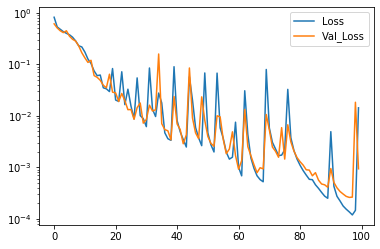

In [0]:
plt.plot(h.history["loss"], label="Loss") # 다소 튀는 현상이 있으나 감소하는 경향을 보임
plt.plot(h.history["val_loss"], label="Val_Loss")
plt.yscale("log")
plt.legend()